## Project: Analyzing and Modeling Activity Recognition Using Wearable Sensor Data

To process and analyze wearable sensor data for human activity recognition using machine learning, including data cleaning, exploratory data analysis (EDA), feature extraction, and building predictive models.

### Load Data

In [5]:
import numpy as np
import pandas as pd

# load features
features = pd.read_csv("UCI HAR Dataset/features.txt",
                      sep='\s+',
                      header = None,
                      names = ["index", "feature name"])
features["feature name"] = features["feature name"].apply(lambda x: x.strip())

# rename duplicate feature names to fit into dataframe
for i, (name, is_duplicate) in enumerate(zip(features["feature name"], 
                                             features["feature name"].duplicated(keep=False))):
    if is_duplicate:
        features.iloc[i, features.columns.get_loc("feature name")] = f"{name}_{i}"
    else:
        features.iloc[i, features.columns.get_loc("feature name")] = name

# load activity labels
activity_labels = pd.read_csv("UCI HAR Dataset/activity_labels.txt",
                             sep='\s+',
                             header = None,
                             names = ["index", "activity label"])

# load train data
X_train = pd.read_csv("UCI HAR Dataset/train/X_train.txt",
                     sep='\s+',
                     header = None,
                     names = features["feature name"])
y_train = pd.read_csv("UCI HAR Dataset/train/y_train.txt",
                     sep='\s+',
                     header = None,
                     names = ["activity label"])
subject_train = pd.read_csv("UCI HAR Dataset/train/subject_train.txt", 
                            sep='\s+', 
                            header=None, 
                            names=['subject_id'])
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("subject_train shape:", subject_train.shape)

# Load test data
X_test = pd.read_csv("UCI HAR Dataset/test/X_test.txt", 
                     sep='\s+', 
                     header=None, 
                     names=features["feature name"])
y_test = pd.read_csv("UCI HAR Dataset/test/y_test.txt", 
                     sep='\s+', 
                     header=None, 
                     names=["activity label"])
subject_test = pd.read_csv("UCI HAR Dataset/test/subject_test.txt", 
                           sep='\s+', 
                           header=None, 
                           names=['subject_id'])
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("subject_test shape:", subject_test.shape)

# Merge train and test datasets
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
subjects = pd.concat([subject_train, subject_test])

X_train shape: (7352, 561)
y_train shape: (7352, 1)
subject_train shape: (7352, 1)
X_test shape: (2947, 561)
y_test shape: (2947, 1)
subject_test shape: (2947, 1)


### Exploratory Data Analysis (EDA)
- Activity and Subject Distribution: Plotted overall distributions; data is relatively balanced with some variance.
- Missing Values: No missing values found.
- Normality Test: Kolmogorov-Smirnov test shows most features are not normally distributed, so z-score is not applicable.
- Outlier Detection: Used IQR * 1.5 to replace outliers with medians.
- Feature Distribution Across Activities: Observed feature variations across activities.
- Correlation Heatmap: Many features are highly correlated, suggesting potential redundancy.

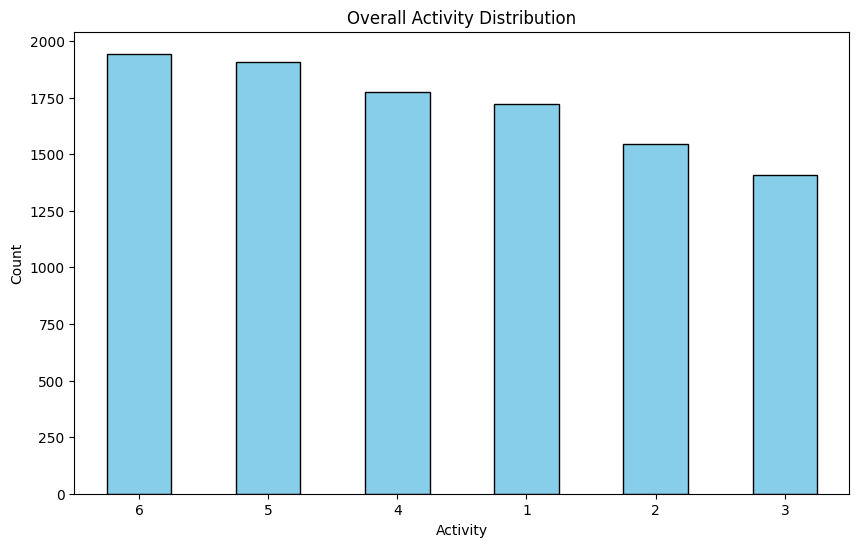

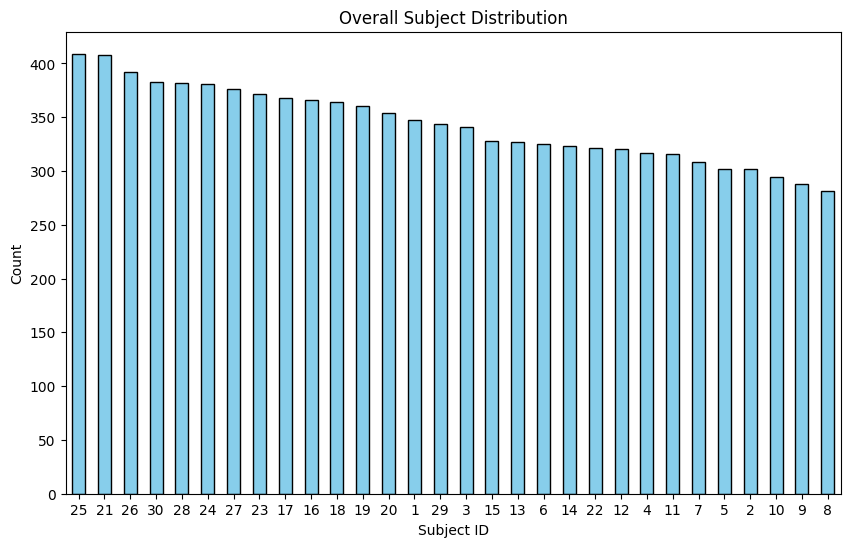

In [6]:
# Visualize data distribution
import matplotlib.pyplot as plt

# overall activity distribution
activity_counts = y["activity label"].value_counts()
plt.figure(figsize=(10,6))
activity_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Overall Activity Distribution")
plt.xlabel("Activity")
plt.ylabel("Count")
plt.xticks(rotation=360)
plt.show()

# overall subject distribution
subject_counts = subjects['subject_id'].value_counts()
plt.figure(figsize=(10,6))
subject_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Overall Subject Distribution")
plt.xlabel("Subject ID")
plt.ylabel("Count")
plt.xticks(rotation=360)
plt.show()

In [7]:
# check missing values
total_missing_count = X.isnull().sum().sum()
print(f"Total missing values: {total_missing_count}")

# check for normality
from scipy.stats import kstest

normal_features = 0
non_normal_features = 0

for feature in X.columns:
    stat, p_value = kstest(X[feature], 'norm')
    if p_value > 0.05:
        normal_features += 1
    else:
        non_normal_features += 1
        
print(f"normal distributed feature count: {normal_features}")
print(f"not normal distributed feature count: {non_normal_features}")

# most features are not normally distributed, use IQR to calculate and replace outliers with median
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

outlier_mask = (X < lower_bound) | (X > upper_bound)
for col in X.columns:
    current_median = X[col].median()
    X.loc[outlier_mask[col], col] = current_median


Total missing values: 0
normal distributed feature count: 0
not normal distributed feature count: 561


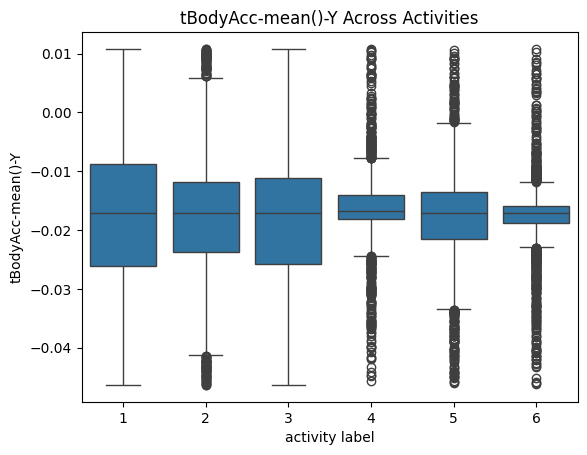

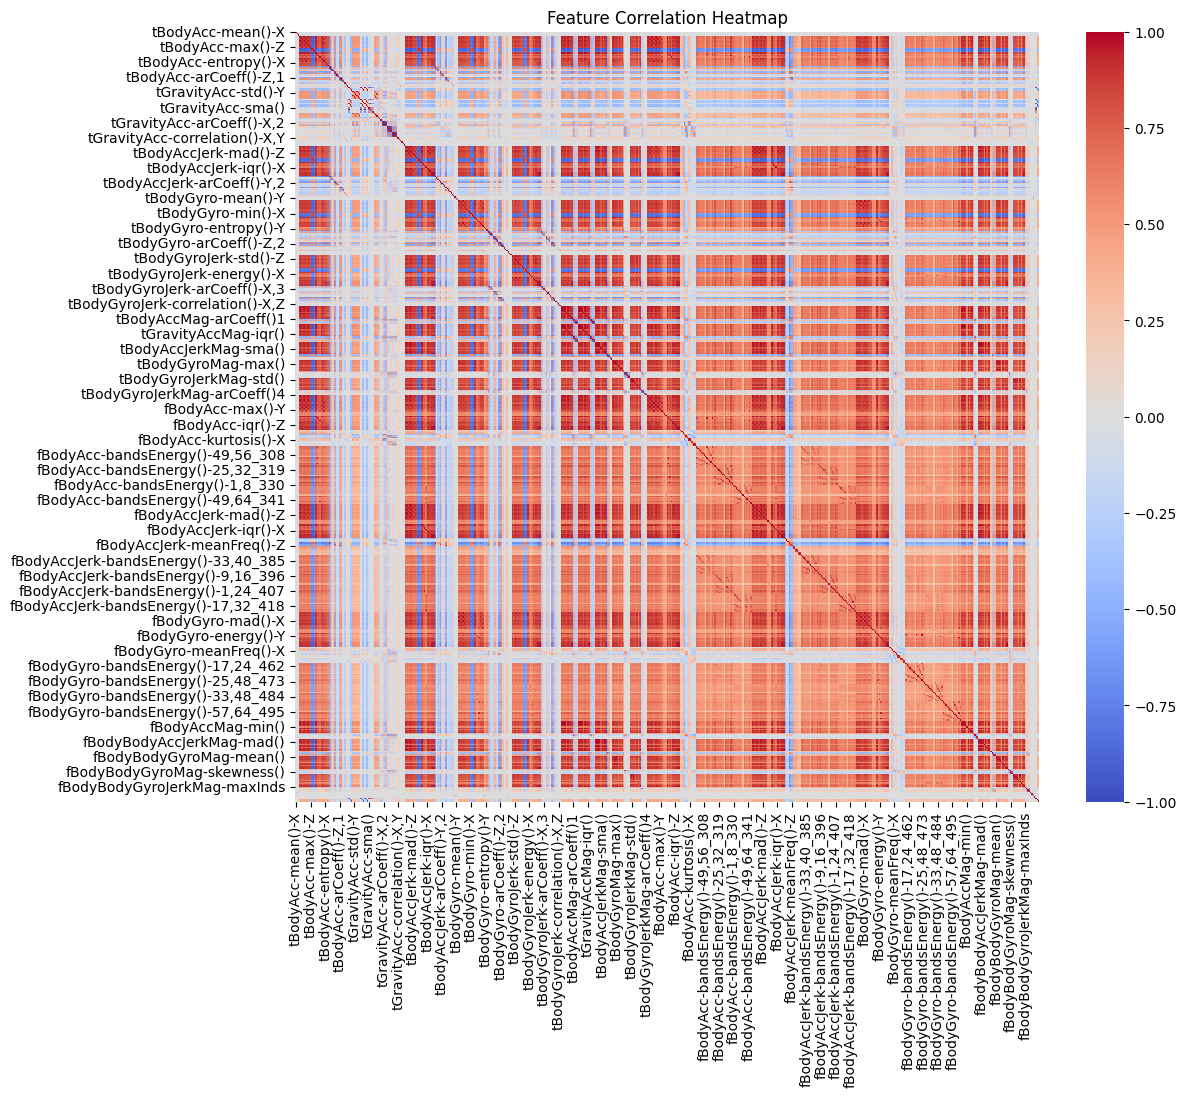

In [8]:
import seaborn as sns

# observe the features across all activities
sns.boxplot(x=y['activity label'], y=X['tBodyAcc-mean()-Y'])
plt.title("tBodyAcc-mean()-Y Across Activities")
plt.xticks(rotation=0)
plt.show()

# Correlation Heatmap to observe the relationship between features
corr_matrix = X.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

### Dimension Reduction
Because the heatmap shows high correlation between features, use PCA to reduce repetitive data.
1. Observe variance explained: choose 100 features with around 95% of data explained
2. Perform PCA: reduce data to 100 features.

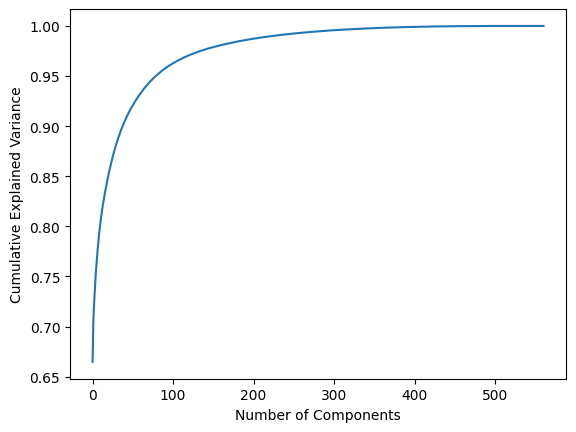

Shape of transformed data: (10299, 100)


In [9]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot cumulative variance
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Perform PCA
# From the plot, 100 components explains around 95% of the variance, so I use 100 components
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)
print("Shape of transformed data:", X_pca.shape)

### Start Training Model
- Random Forest: 91% accuracy
- Logistic Regression: 94% accuracy
- Support Vector Machine: 95% accuracy

In [10]:
# Separate training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=33)

y_train = y_train.to_numpy().ravel()
y_test = y_test.to_numpy().ravel()

In [13]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Model Evaluation
print(classification_report(y_test, y_pred))f

              precision    recall  f1-score   support

           1       0.97      0.98      0.98       328
           2       0.96      0.98      0.97       300
           3       0.97      0.95      0.96       279
           4       0.87      0.82      0.84       360
           5       0.82      0.89      0.86       370
           6       0.93      0.90      0.91       423

    accuracy                           0.92      2060
   macro avg       0.92      0.92      0.92      2060
weighted avg       0.92      0.92      0.92      2060



In [14]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Make predictions on the test set
y_pred_logreg = logreg.predict(X_test)

# Model Evaluation
print(classification_report(y_test, y_pred_logreg))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       328
           2       0.99      1.00      1.00       300
           3       1.00      1.00      1.00       279
           4       0.86      0.82      0.84       360
           5       0.88      0.88      0.88       370
           6       0.89      0.92      0.90       423

    accuracy                           0.93      2060
   macro avg       0.94      0.94      0.94      2060
weighted avg       0.93      0.93      0.93      2060



In [12]:
# Support Vector Machine - kernel='rbf'
from sklearn.svm import SVC
from sklearn.metrics import classification_report

svm = SVC(kernel='rbf', gamma='scale', random_state=42)
svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = svm.predict(X_test)

# Model Evaluation
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       328
           2       1.00      1.00      1.00       300
           3       1.00      1.00      1.00       279
           4       0.91      0.88      0.90       360
           5       0.91      0.93      0.92       370
           6       0.94      0.94      0.94       423

    accuracy                           0.96      2060
   macro avg       0.96      0.96      0.96      2060
weighted avg       0.96      0.96      0.96      2060

